In [1]:
import json
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
datastore = []
with open(r"D:\TensorflowPractice\venv\Datasets\sarcasm\Sarcasm_Headlines_Dataset.json",'r') as line:
     for f in line:
        datastore.append(json.loads(f))
sentences = []
labels =[]
for i in datastore:
    sentences.append(i['headline'])
    labels.append(i['is_sarcastic'])

In [3]:
TRAINING_SIZE = 20000
VOCAB_SIZE = 10000
MAX_LENGTH = 32
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [4]:
training_sentences = sentences[:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]
training_labels = labels[:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

In [5]:
vectorize_layer = tf.keras.layers.TextVectorization()
vectorize_layer.adapt(training_sentences)

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((training_sentences,training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels))

In [7]:
def preprocessing_func(dataset):
    data_sequences = dataset.map(
        lambda text, label: (vectorize_layer(text), label)
    )

    data_sequences  = data_sequences.ragged_batch(
        batch_size = data_sequences.cardinality()
    )

    sequences, labels = data_sequences.get_single_element()

    padded_sequences = tf.keras.utils.pad_sequences(
        sequences.numpy(),
        maxlen = MAX_LENGTH,
        truncating = TRUNC_TYPE,
        padding = PADDING_TYPE
    ) 

    padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
    labels  = tf.data.Dataset.from_tensor_slices(labels)

    dataset_vectorized = tf.data.Dataset.zip(padded_sequences,labels)

    return dataset_vectorized

In [8]:
training_data_vectorized = train_dataset.apply(preprocessing_func)
testing_data_vectorized = test_dataset.apply(preprocessing_func)

In [9]:
# View 2 training sequences and its labels
for example in training_data_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,   319, 13005,   943,  4079,  2366,    47,   366,
          94,  2026,     6,  2653,  9470], dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           4,  7185,  3128,  3305,    28,     2,   152, 13718,   358,
        2902,     6,   236,     9,   844], dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)



In [10]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize and batch the datasets for training
train_dataset_final = (training_data_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (testing_data_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

In [11]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

In [12]:
# Parameters
EMBEDDING_DIM = 16
LSTM_DIM = 32
DENSE_DIM = 24

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=100000,output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM,activation='relu'),
    tf.keras.layers.Dense(1,'sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 32, 16)         │     1,600,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,614,129 (6.16 MB)

 Trainable params: 1,614,129 (6.16 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
NUM_EPOCHS = 10

# Train the model
history_lstm = model.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.6890 - loss: 0.5392 - val_accuracy: 0.8536 - val_loss: 0.3434
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9073 - loss: 0.2305 - val_accuracy: 0.8504 - val_loss: 0.3831
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9571 - loss: 0.1216 - val_accuracy: 0.8419 - val_loss: 0.5275
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9795 - loss: 0.0683 - val_accuracy: 0.8433 - val_loss: 0.6113
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9873 - loss: 0.0435 - val_accuracy: 0.8286 - val_loss: 0.7364
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9933 - loss: 0.0254 - val_accuracy: 0.8317 - val_loss: 0.8049
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9952 - loss: 0.0181 - val_accuracy: 0.8238 - val_loss: 0.9683
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9956 - loss: 0.0148 - val_ac

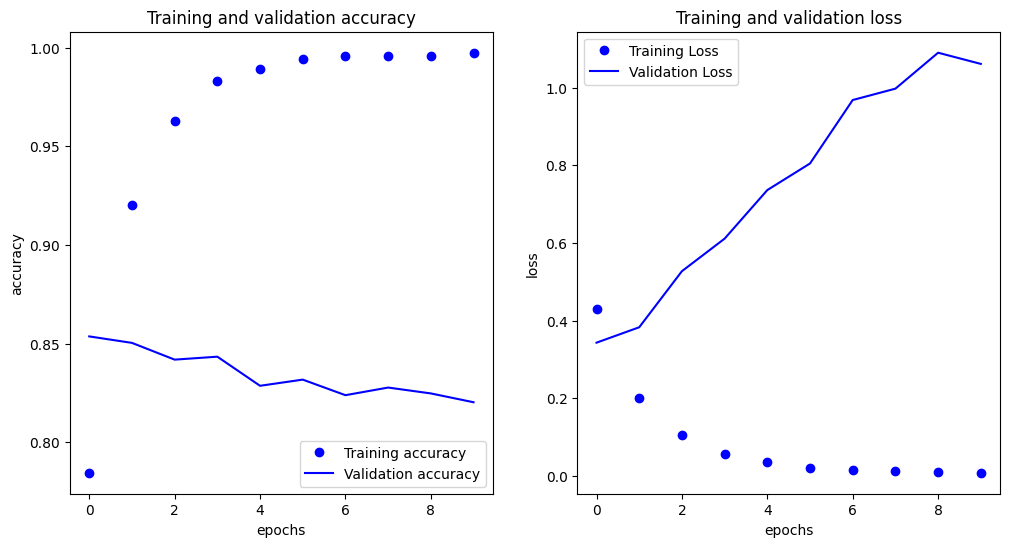

In [22]:
plot_loss_acc(history_lstm)